In [1]:
import numpy as np
import matplotlib.pyplot as plt

import corner
import emcee
import qnmfits

from scipy.interpolate import InterpolatedUnivariateSpline as spline

from matplotlib.patches import Ellipse

In [2]:
rng = np.random.default_rng()

In [3]:
sim = qnmfits.SXS(305, zero_time=(2,2))

# Get the next highest level for waveform error estimation
sim_ll = qnmfits.SXS(305, zero_time=(2,2), lev_minus_highest=-1)

/Users/eliot/Documents/Research/Ringdown/qnmfits/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5


In [4]:
# Analysis start time and duration
t0 = 20
T = 100
analysis_mask = (sim.times > t0) & (sim.times < t0+T)

# Modes we'll include in the fit
qnms = [(ell,2,n,1) for ell in [2,3] for n in [0,1]]
spherical_modes = [(2,2), (3,2)]

n_qnms = len(qnms)

## Least-squares fit

In [5]:
ls_fit = qnmfits.multimode_ringdown_fit(
    sim.times,
    sim.h,
    modes=qnms,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=t0,
    T=T,
    spherical_modes=spherical_modes,
)

In [6]:
for label, amplitude in zip(ls_fit['mode_labels'], ls_fit['C']):
    print(f"{label}: {np.real(amplitude):.2e}, {np.imag(amplitude):.2e} / {abs(amplitude):.2e}, {np.angle(amplitude):.2f}")

(2, 2, 0, 1): -1.72e-01, 3.81e-02 / 1.77e-01, 2.92
(2, 2, 1, 1): 1.26e-02, 1.92e-02 / 2.30e-02, 0.99
(3, 2, 0, 1): -2.77e-03, 5.59e-03 / 6.24e-03, 2.03
(3, 2, 1, 1): 7.76e-04, -1.49e-03 / 1.68e-03, -1.09


In [7]:
# Store the least-squares result for later

ls_re_c = np.real(ls_fit['C'])
ls_im_c = np.imag(ls_fit['C'])

ls_re_c_im_c = []
for re_c, im_c in zip(ls_re_c, ls_im_c):
    ls_re_c_im_c.append(re_c)
    ls_re_c_im_c.append(im_c)

ls_a = np.abs(ls_fit['C'])
ls_phi = np.angle(ls_fit['C'])
ls_a_phi = np.concatenate((ls_a, ls_phi))

## Likelihood fits

We need to pick a estimate of the waveform error. We can use the difference in the two highest levels as an initial guess:

In [8]:
# Evaluate the lower level waveform on the same times as the highest level waveform
sim_ll_interp = {}
for ell, m in sim_ll.h.keys():
    sim_ll_interp[ell,m] = spline(sim_ll.times, np.real(sim_ll.h[ell,m]), ext=1)(sim.times) + \
    1j*spline(sim_ll.times, np.imag(sim_ll.h[ell,m]), ext=1)(sim.times)

# Compute the difference in the levels, R. Note that we're not doing any alignment here.
R = {}
for ell, m in sim.h.keys():
    R[ell,m] = sim.h[ell,m] - sim_ll_interp[ell,m]

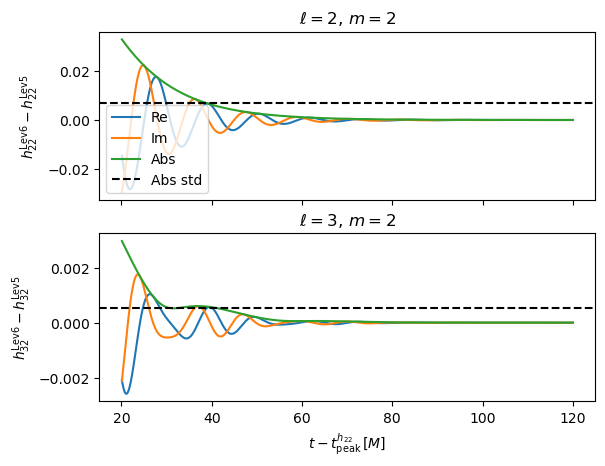

In [9]:
# We can use the difference in the levels to get an initial estimate of the error
sigma_dict = {}

fig, axs = plt.subplots(len(spherical_modes), 1, sharex=True)

for i, (ell,m) in enumerate(spherical_modes):

    axs[i].plot(sim.times[analysis_mask], np.real(R[ell,m])[analysis_mask], label='Re')
    axs[i].plot(sim.times[analysis_mask], np.imag(R[ell,m])[analysis_mask], label='Im')
    axs[i].plot(sim.times[analysis_mask], np.abs(R[ell,m])[analysis_mask], label='Abs')

    abs_std = np.std(np.abs(R[ell,m])[analysis_mask])
    sigma_dict[ell,m] = abs_std
    axs[i].axhline(abs_std, color='k', ls='--', label='Abs std')

    axs[i].set_ylabel(f'$h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev}}} - h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev-1}}}$')
    axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

axs[-1].set_xlabel('$t-t_\mathrm{peak}^{h_{22}}\, [M]$')

axs[0].legend();

### `emcee` fit 

Here we do an analysis with a constant $\sigma$ based on the above estimate (this takes about 4 minutes to run for me - I don't do an emcee analysis with a non-diagonal covariance because it takes too long).

In [10]:
frequencies = qnmfits.qnm.omega_list(qnms, Mf=sim.Mf, chif=sim.chif_mag)

In [11]:
mixing_coefficients = {}
for ell, m in spherical_modes:
    indices = [(ell,m)+qnm for qnm in qnms]
    mixing_coefficients[(ell,m)] = qnmfits.qnm.mu_list(indices, sim.chif_mag)

In [12]:
def ringdown_model(theta, times, frequencies, mixing_coefficients):
    """
    Ringdown model class.

    Parameters
    ----------
    times : array-like
        The time values at which the model is evaluated.
    theta : dict
        Contains re[C] and im[C] for each requested mode.
    frequencies : array-like
        The frequencies corresponding to each qnm.
    mixing_coefficients : dict
        Dictionary with keys (ell,m) for each spherical mode in the fit. The
        values are lists of mixing coefficients for each qnm in the fit, 
        ordered as qnms.
    """
    model_dict = {}

    for (ell,m), mu_list in mixing_coefficients.items():

        model = np.zeros_like(times, dtype=complex)

        real_amplitudes = theta[::2]
        imag_amplitudes = theta[1::2]
    
        for re_c, im_c, omega, mu in zip(real_amplitudes, imag_amplitudes, frequencies, mu_list):
            model += mu*(re_c+1j*im_c)*np.exp(-1j*omega*times)

        model_dict[(ell,m)] = {'plus': np.real(model), 'cross': -np.imag(model)}
    
    return model_dict

In [13]:
# We re-define the times to start at 0 for our likelihood to work
analysis_times = sim.times[analysis_mask] - t0

analysis_data_dict = {
    (ell,m): {
        'plus': np.real(sim.h[ell,m])[analysis_mask], 
        'cross': -np.imag(sim.h[ell,m])[analysis_mask]
        } 
    for ell, m in spherical_modes
    }

In [14]:
def log_likelihood(theta, data_dict, sigma_dict, times, frequencies, mixing_coefficients):

    h_theta_dict = ringdown_model(theta, times, frequencies, mixing_coefficients)

    logl = 0

    for (ell,m), data in data_dict.items():

        plus = data['plus']
        cross = data['cross']

        sigma = sigma_dict[ell,m]

        h_theta = h_theta_dict[ell,m]

        logl += -0.5*sum(((plus-h_theta['plus'])/sigma)**2)
        logl += -0.5*sum(((cross-h_theta['cross'])/sigma)**2)

    return logl

def log_prior(theta):
    # Check whether any param is outside of its appropriate range
    lower = -1
    upper = 1
    if np.all(np.logical_and(lower <= theta, theta <= upper)):
        return 0.0
    return -np.inf

def log_probability(theta, data_dict, sigma_dict, times, frequencies, mixing_coefficients):

    # Calculate log prior. If log prior = 0, then probability is 0.
    logp = log_prior(theta)
    if not np.isfinite(logp):
        return -np.inf
    
    # Return log prior + log likelihood
    return logp + log_likelihood(theta, data_dict, sigma_dict, times, frequencies, mixing_coefficients)

In [15]:
# Pick a set of random starting locations around the least-squares result
pos = ls_re_c_im_c + 1e-5*rng.standard_normal((100, 2*n_qnms))
nwalkers, ndim = pos.shape

# create sampler and run
sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim, 
    log_probability, 
    args=(
        analysis_data_dict, 
        sigma_dict,
        analysis_times,  
        frequencies,
        mixing_coefficients
        ),
)
_ = sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [04:17<00:00, 19.38it/s]


In [16]:
tau = sampler.get_autocorr_time(quiet=True)
print(tau)

[80.19025485 88.06370259 81.0146291  90.08305384 76.27581449 73.45152135
 75.94032765 77.18546249]


Note that we are shifted with respect to the least-square fit values. This is because we are assuming different noise levels in each spherical mode.

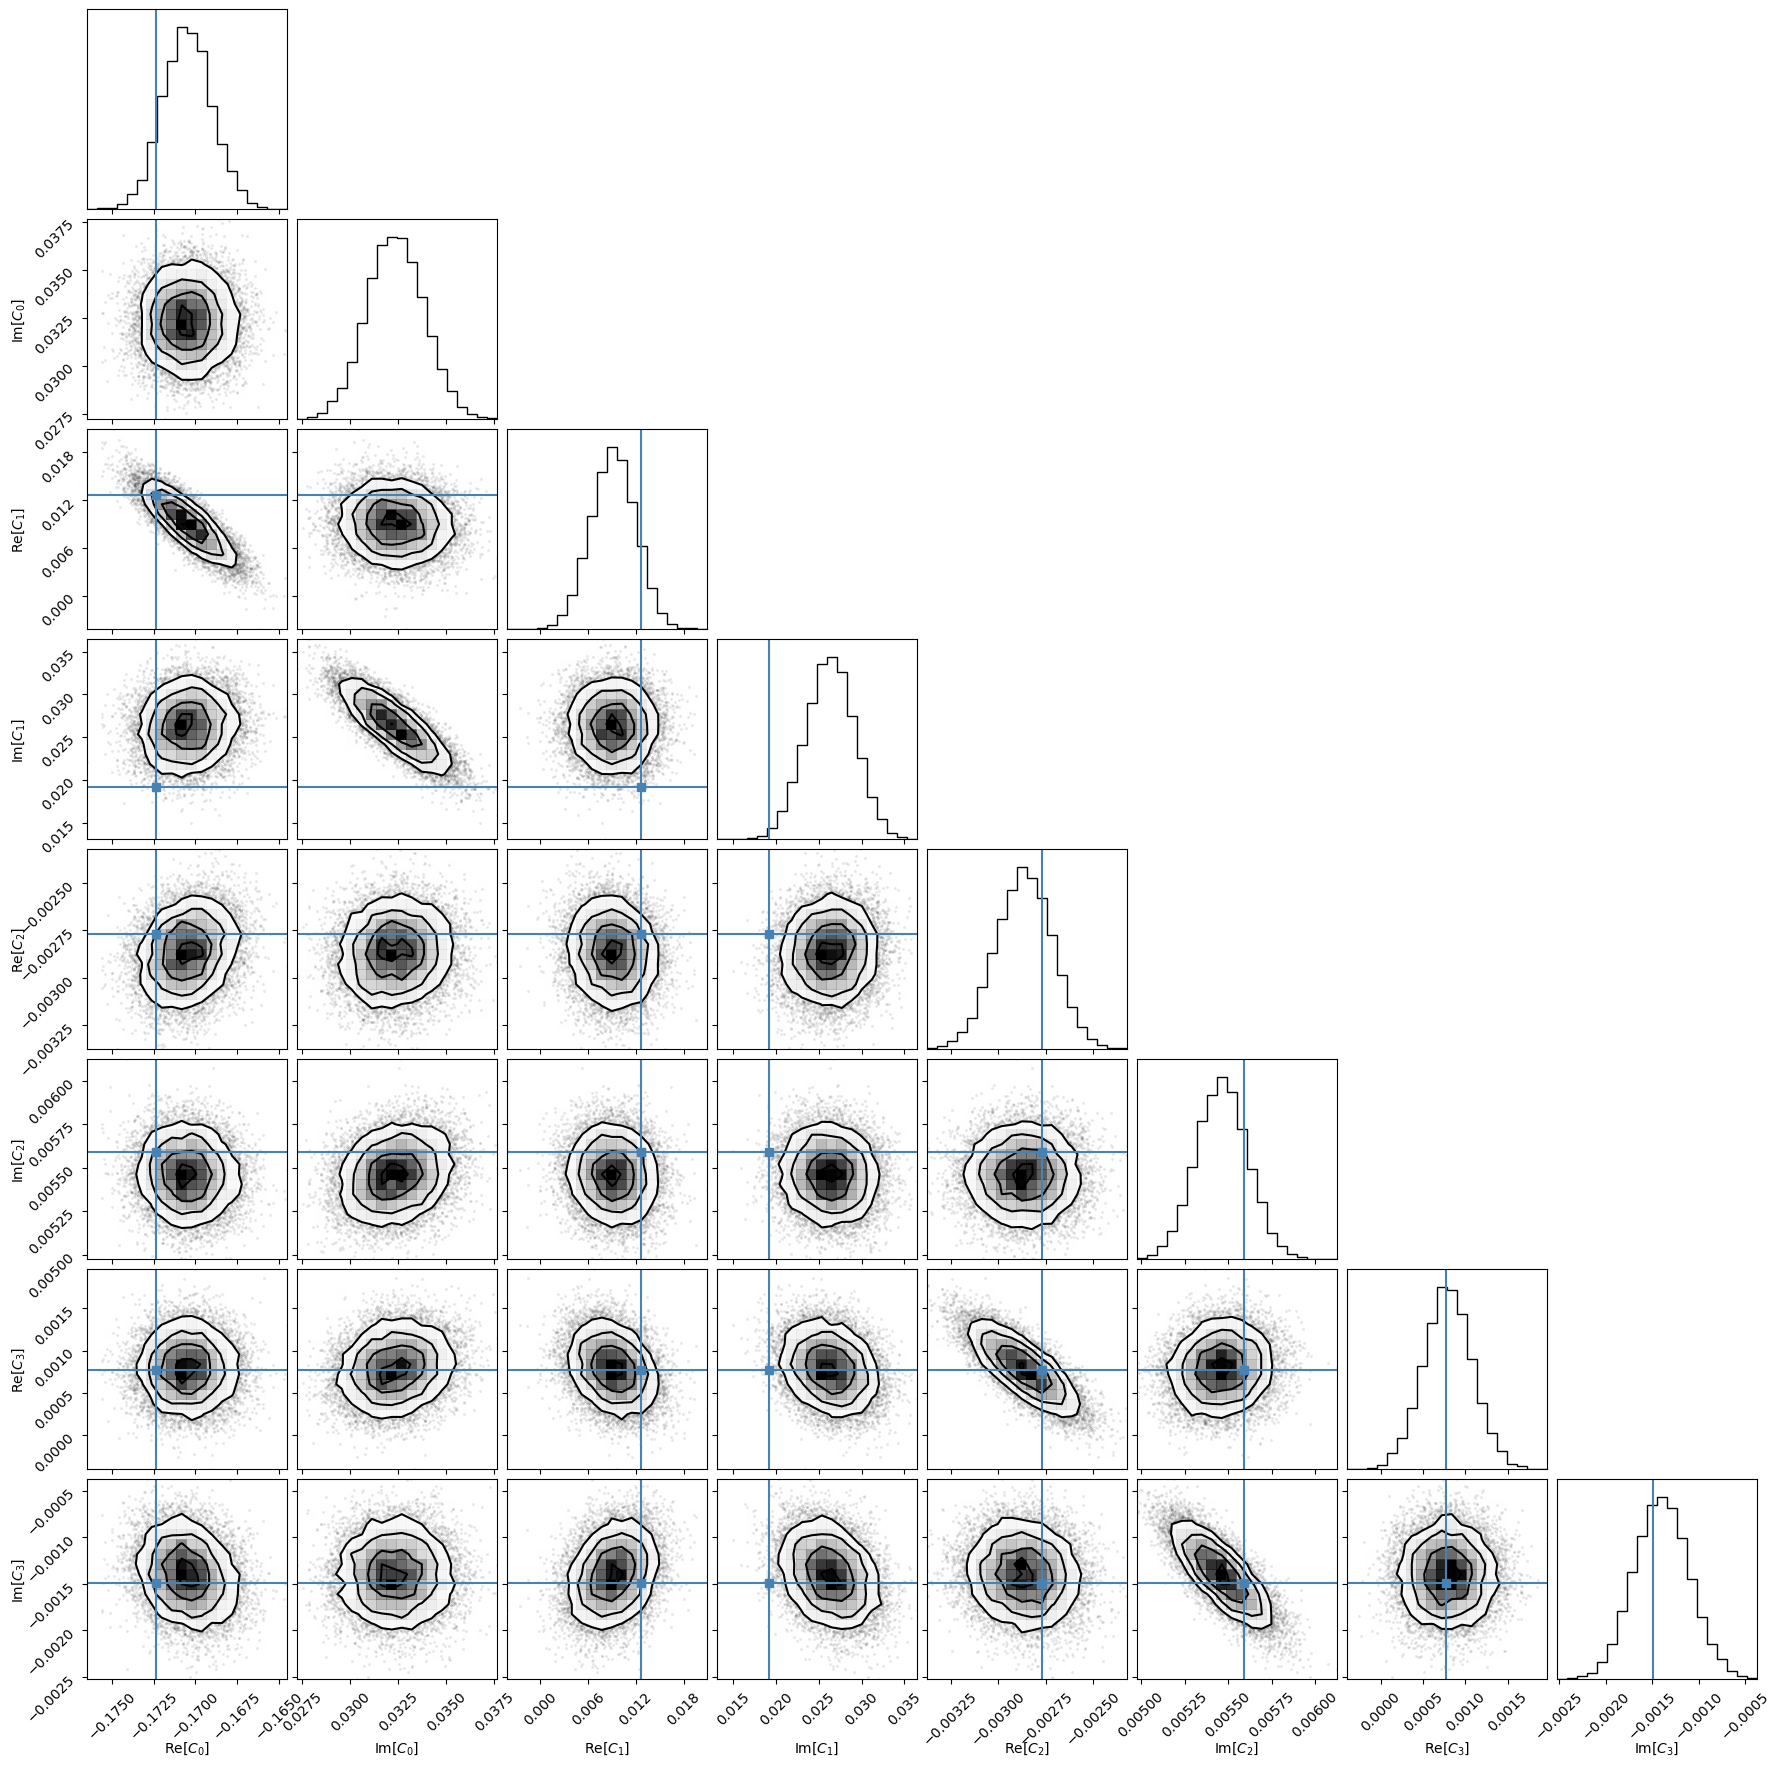

In [17]:
emcee_samples = sampler.get_chain(
    discard=int(2*np.mean(tau)), 
    thin=int(np.mean(tau)/2), 
    flat=True
    )

real_labels = [f'$\mathrm{{Re}}[C_{i}]$' for i in range(n_qnms)]
imag_labels = [f'$\mathrm{{Im}}[C_{i}]$' for i in range(n_qnms)]
labels = []
for real, imag in zip(real_labels, imag_labels):
    labels.append(real)
    labels.append(imag)

_ = corner.corner(
    emcee_samples, 
    labels=labels,
    truths=ls_re_c_im_c,
)

Transform to the usual amplitude-phase space.

In [18]:
transformed_emcee_amplitudes = []
transformed_emcee_phases = []
for i in range(n_qnms):
    re_c = emcee_samples[:, 2*i]
    im_c = emcee_samples[:, 2*i+1]
    c = re_c + 1j*im_c
    transformed_emcee_amplitudes.append(np.abs(c))
    transformed_emcee_phases.append(np.angle(c))
    
transformed_emcee_samples = np.array(
    transformed_emcee_amplitudes + transformed_emcee_phases
    ).T

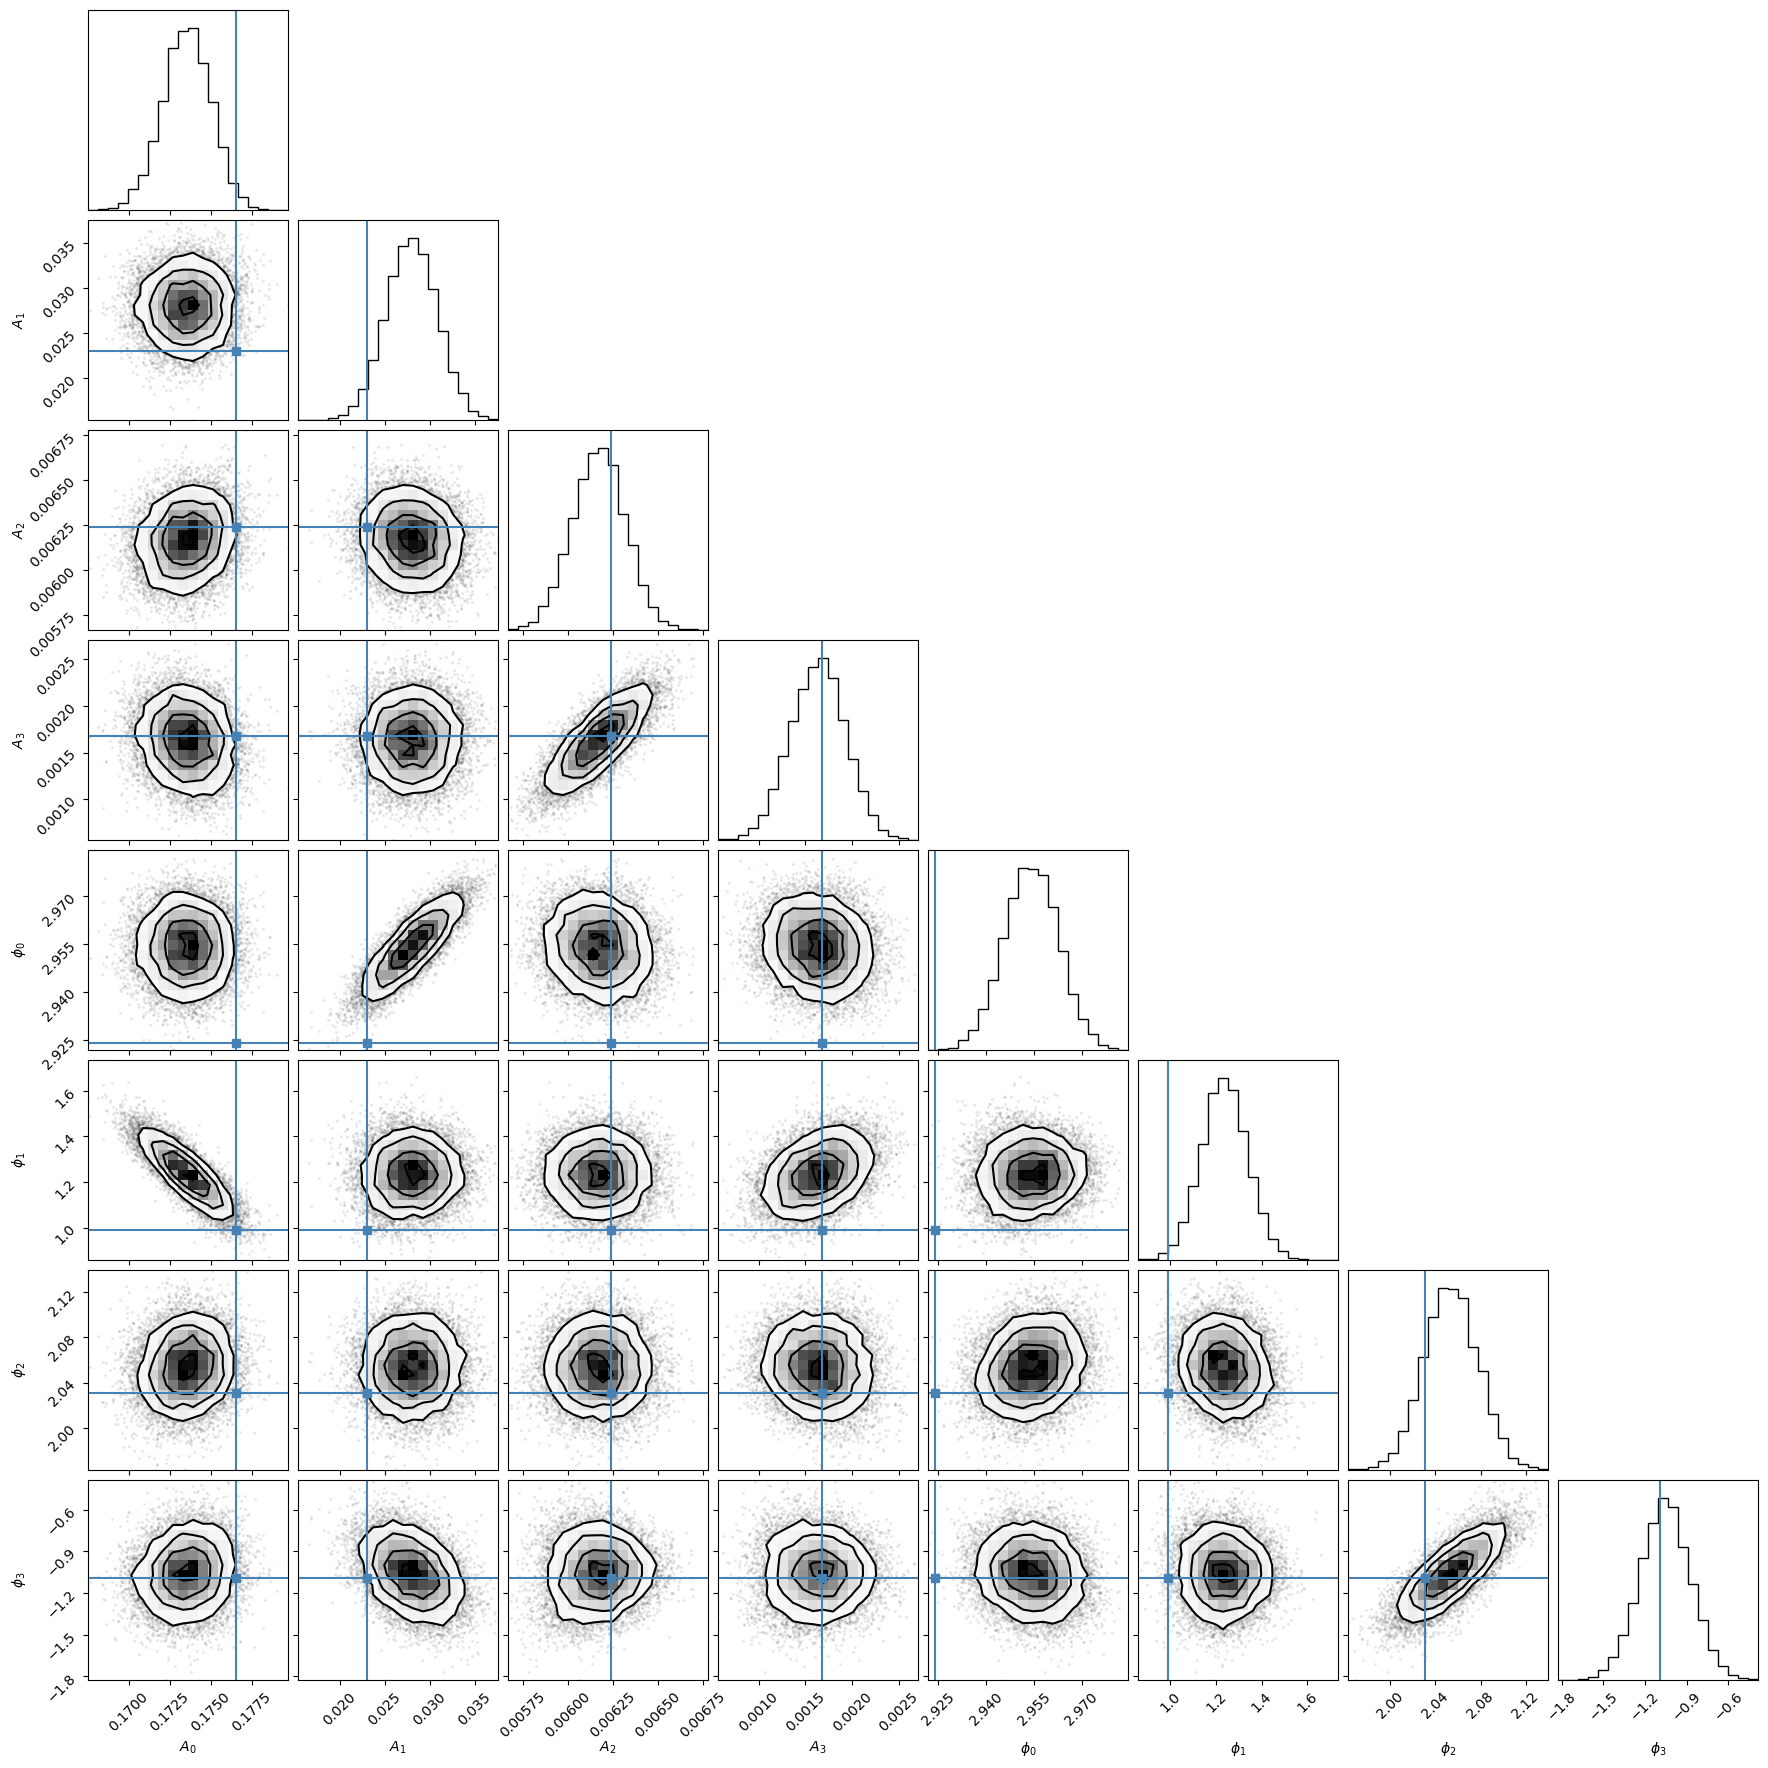

In [19]:
amplitude_labels = [f'$A_{i}$' for i in range(n_qnms)]
phase_labels = [f'$\phi_{i}$' for i in range(n_qnms)]
transformed_labels = amplitude_labels + phase_labels

_ = corner.corner(
    transformed_emcee_samples, 
    labels=transformed_labels,
    truths=ls_a_phi
)

### Fisher matrix

We first reproduce the abpve constant-$\sigma$ analysis with the Fisher matrix, before looking at more complicated noise descriptions.

In [20]:
cov_dict = {}
cov_inv_dict = {}
for ell, m in spherical_modes:
    cov_dict[ell,m] = np.eye(len(analysis_times))*sigma_dict[ell,m]**2
    cov_inv_dict[ell,m] = np.linalg.inv(cov_dict[ell,m])

In [21]:
a_dict = {}
for (ell,m), mu_list in mixing_coefficients.items():
    a_dict[ell,m] = np.array([
        mu_list[i]*np.exp(-1j*frequencies[i]*analysis_times) for i in range(len(frequencies))
        ]).T

In [22]:
def calculate_fisher_matrix(a_dict, cov_inv_dict):
    fisher_matrix = np.zeros((2*n_qnms, 2*n_qnms))
    for ell, m in spherical_modes:
        a = a_dict[ell,m]
        cov_inv = cov_inv_dict[ell,m]
        for i in range(n_qnms):
            for j, part in enumerate(['Re', 'Im']):
                for i_ in range(n_qnms):
                    for j_, part_ in enumerate(['Re', 'Im']):
                        A = a[:,i] if part =='Re' else 1j*a[:,i]
                        B = a[:,i_] if part_=='Re' else 1j*a[:,i_]
                        fisher_matrix[2*i+j,2*i_+j_] += np.real(
                            np.einsum('i,ij,j', A, cov_inv, np.conjugate(B))
                            )
    return fisher_matrix

In [23]:
fisher_matrix = calculate_fisher_matrix(a_dict, cov_inv_dict)

In [24]:
covariance_matrix = np.linalg.inv(fisher_matrix)

Note that we'll need to find the posterior means, which can be done via a weighted least-squares fit.

In [25]:
def weighted_ls_fit(cov_dict, a_dict, data_dict):

    L_dict = {}
    for ell, m in spherical_modes:
        L_dict[ell,m] = np.linalg.cholesky(cov_dict[ell,m])

    L_inv_dict = {}
    for ell, m in spherical_modes:
        L_inv_dict[ell,m] = np.linalg.inv(L_dict[ell,m])

    weighted_a_stacked = np.zeros((len(spherical_modes)*len(analysis_times), n_qnms), dtype=complex)
    for i, (ell,m) in enumerate(spherical_modes):
        weighted_a = L_inv_dict[ell,m] @ a_dict[ell,m]
        weighted_a_stacked[i*len(analysis_times):(i+1)*len(analysis_times),:] = weighted_a

    weighted_data_stacked = np.zeros(len(spherical_modes)*len(analysis_times), dtype=complex)
    for i, (ell,m) in enumerate(spherical_modes):
        weighted_plus = L_inv_dict[ell,m] @ data_dict[ell,m]['plus']
        weighted_cross = L_inv_dict[ell,m] @ data_dict[ell,m]['cross']
        weighted_data_stacked[i*len(analysis_times):(i+1)*len(analysis_times)] = weighted_plus - 1j*weighted_cross

    weighted_ls_C, res, rank, s = np.linalg.lstsq(weighted_a_stacked, weighted_data_stacked, rcond=None)

    return weighted_ls_C

In [26]:
weighted_ls_C = weighted_ls_fit(cov_dict, a_dict, analysis_data_dict)

weighted_ls_re_c_im_c = []
for c in weighted_ls_C:
    weighted_ls_re_c_im_c.append(np.real(c))
    weighted_ls_re_c_im_c.append(np.imag(c))

In [27]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an ellipse representing the covariance matrix cov centered at pos.
    Parameters:
    - cov: The 2x2 covariance matrix.
    - pos: The center position of the ellipse (mean).
    - nstd: The number of standard deviations to determine the ellipse's radii.
    - ax: The axes to plot on.
    - kwargs: Additional arguments to pass to the Ellipse patch.
    """
    
    # Calculate the eigenvalues and eigenvectors
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    
    # Calculate the angle of rotation
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    
    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    
    # Plot the ellipse
    ellipse = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellipse)

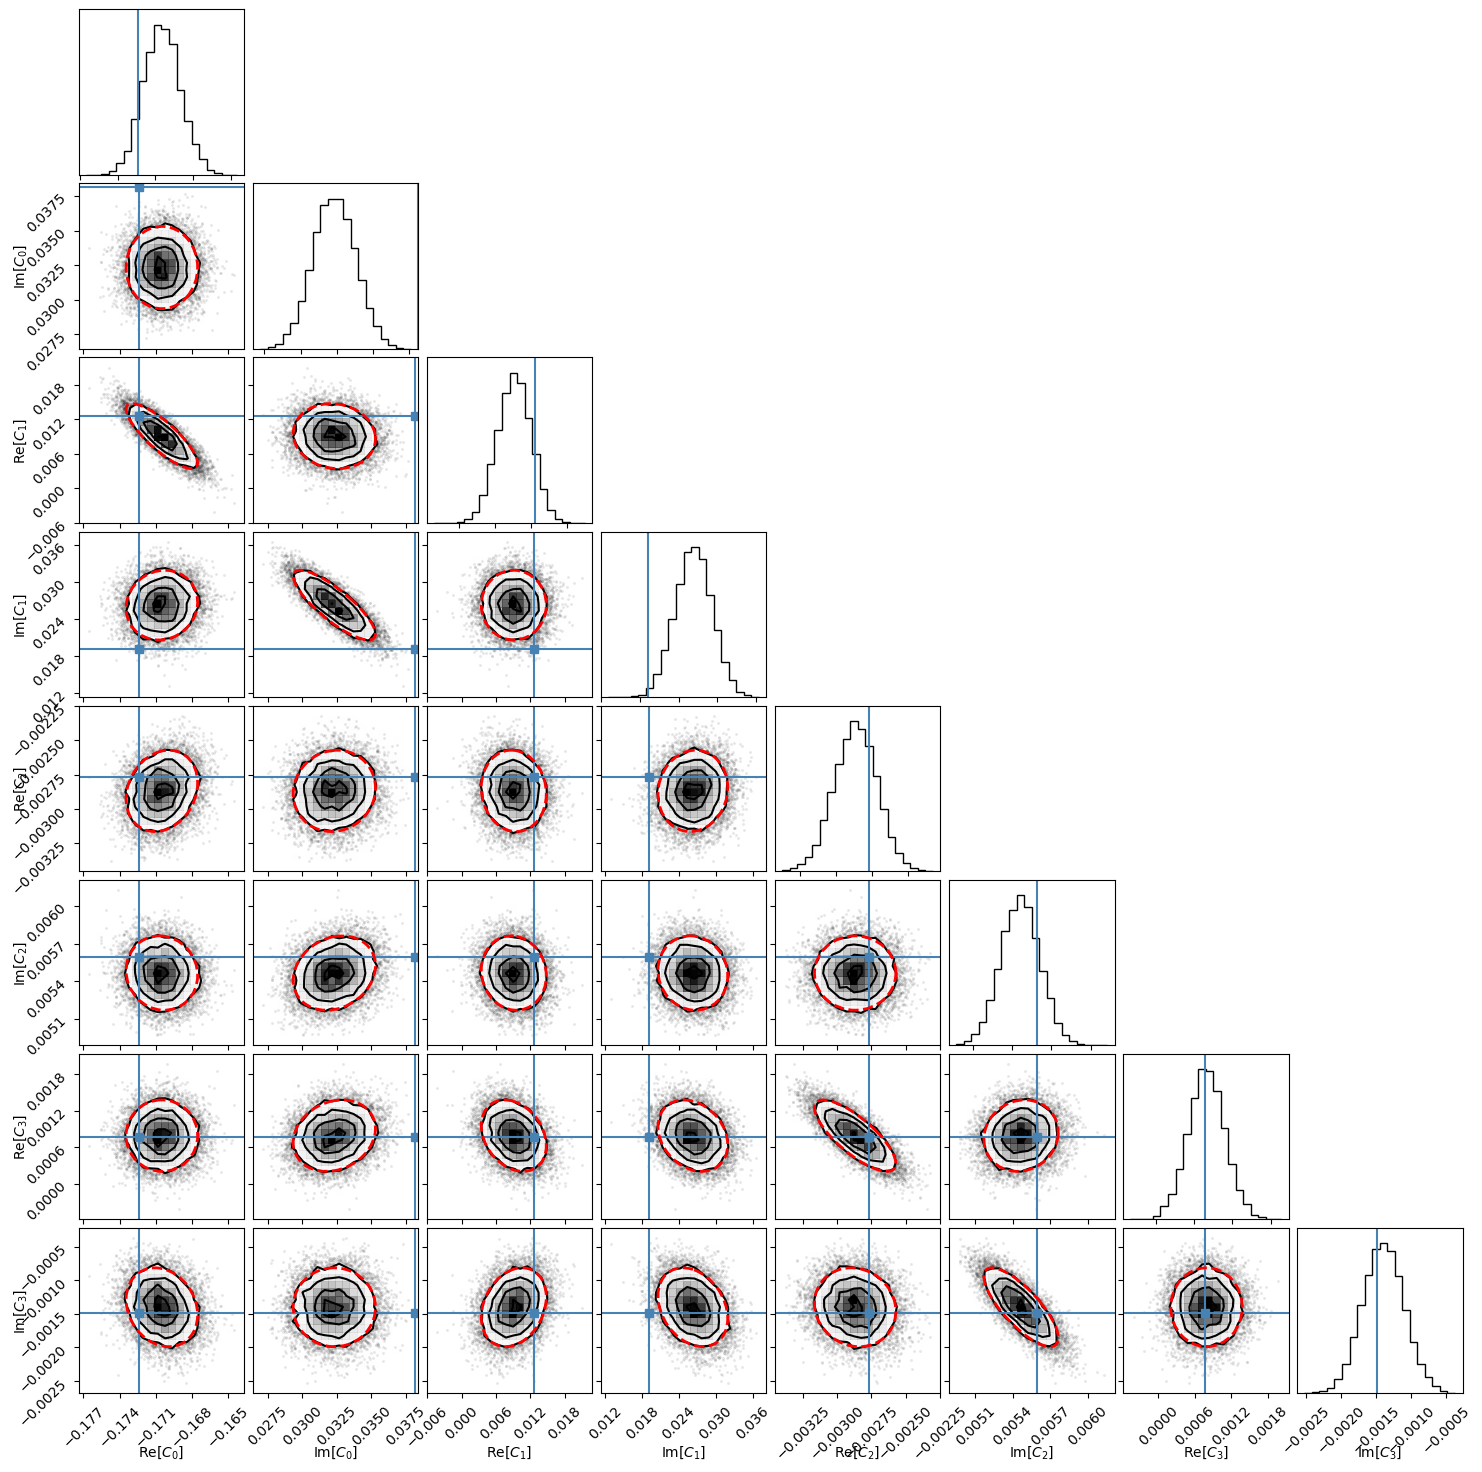

In [28]:
fig, axs = plt.subplots(2*n_qnms, 2*n_qnms, figsize=(15,15))

corner.corner(
    emcee_samples, 
    labels=labels,
    truths=ls_re_c_im_c,
    fig=fig
)

for i in range(2*n_qnms):
    for j in range(i):
        plot_cov_ellipse(
            np.array(covariance_matrix)[[j, i]][:, [j, i]], 
            [weighted_ls_re_c_im_c[j], weighted_ls_re_c_im_c[i]], 
            ax=axs[i,j], 
            edgecolor='red', 
            lw=2, 
            linestyle='--',
            fill=False, 
            zorder=5,
            nstd=2
            )

### Fisher matrix with non-diagonal covariance

We can try and construct a kernel that mimics the difference between the two highest CCE levels.

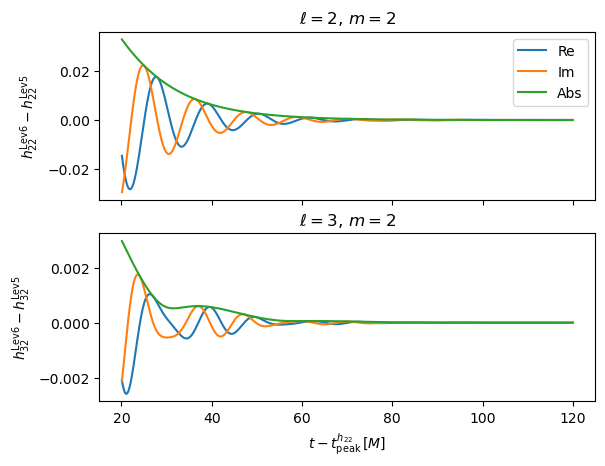

In [29]:
fig, axs = plt.subplots(len(spherical_modes), 1, sharex=True)

for i, (ell,m) in enumerate(spherical_modes):

    axs[i].plot(sim.times[analysis_mask], np.real(R[ell,m])[analysis_mask], label='Re')
    axs[i].plot(sim.times[analysis_mask], np.imag(R[ell,m])[analysis_mask], label='Im')
    axs[i].plot(sim.times[analysis_mask], np.abs(R[ell,m])[analysis_mask], label='Abs')

    axs[i].set_ylabel(f'$h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev}}} - h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev-1}}}$')
    axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

axs[-1].set_xlabel('$t-t_\mathrm{peak}^{h_{22}}\, [M]$')

axs[0].legend();

Inspect the frequencies of $R$ to help construct a kernel:

In [30]:
R_foft_dict = {}
for (ell,m) in spherical_modes:
    
    # Calculate the phase of the complex data
    phase = np.unwrap(np.angle(R[ell,m][analysis_mask]))
    
    # Calculate the derivative using splines
    phasedot = spline(analysis_times, phase).derivative()(analysis_times)
    
    # Store to dictionary
    R_foft_dict[ell,m] = np.abs(phasedot)/(2*np.pi)

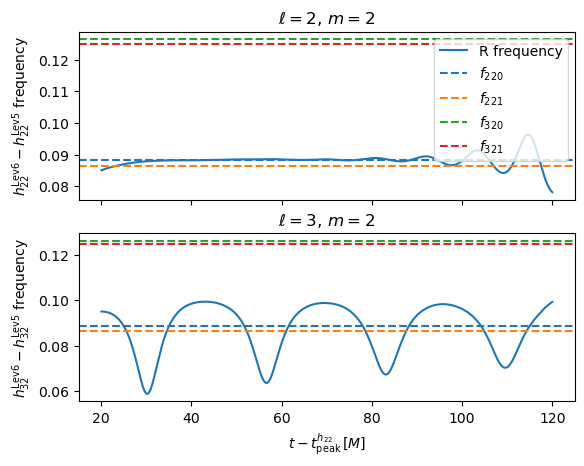

In [31]:
fig, axs = plt.subplots(len(spherical_modes), 1, sharex=True)

for i, (ell,m) in enumerate(spherical_modes):

    axs[i].plot(sim.times[analysis_mask], R_foft_dict[ell,m], label='R frequency')

    for j, (ellp, mp, n, sign) in enumerate(qnms):
        omega_ellmn = qnmfits.qnm.omega(ellp, mp, n, sign, Mf=sim.Mf, chif=sim.chif_mag)
        axs[i].axhline(
            np.real(omega_ellmn/(2*np.pi)),
            ls='--',
            c=f'C{j}',
            label=f'$f_{{{ellp}{mp}{n}}}$'
            )

    axs[i].set_ylabel(f'$h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev}}} - h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev-1}}}$ frequency')
    axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

axs[-1].set_xlabel('$t-t_\mathrm{peak}^{h_{22}}\, [M]$')

axs[0].legend();

The fundamental mode frequency seems to work well for both $R_{22}$ and $R_{32}$. We can use the same kernel, but with different amplitudes:

In [32]:
def damped_cosine_kernel(x1, x2, sigma, length_scale, period):
    """Damped cosine kernel with squared exponential decay."""
    dist = np.abs(x1 - x2)
    return sigma**2 * np.exp(-dist**2 / (2*length_scale**2)) * np.cos(2 * np.pi * dist / period)

def decaying_weight(x, sigma_decay=5.0):
    """Weighting function to ensure decay towards zero for large x."""
    return np.exp(-x**2 / (2 * sigma_decay**2))

def conditioned_periodic_kernel(x1, x2, sigma, l, p, sigma_decay):
    """Damped cosine kernel with decay induced by a weighting function."""
    w1 = decaying_weight(x1, sigma_decay)
    w2 = decaying_weight(x2, sigma_decay)
    base_kernel = damped_cosine_kernel(x1, x2, sigma, l, p)
    return w1 * w2 * base_kernel

In [33]:
# Kernel parameters
hyperparam_dict = {}
for ell, m in spherical_modes:
    hyperparam_dict[ell,m] = {
        'sigma': sigma_dict[ell,m],
        'length_scale': -1/np.imag(frequencies[0]),
        'period': 2*np.pi/np.real(frequencies[0]),
        'sigma_decay': -2/np.imag(frequencies[0])
    }

In [34]:
# Construct the kernels

n_times = len(analysis_times)

K_dict = {}

for (ell,m), hyperparams in hyperparam_dict.items():
    K = np.zeros((n_times, n_times))
    for i in range(n_times):
        for j in range(n_times):
            K[i,j] = conditioned_periodic_kernel(
                analysis_times[i], 
                analysis_times[j], 
                hyperparams['sigma'], 
                hyperparams['length_scale'], 
                hyperparams['period'], 
                hyperparams['sigma_decay']
                )
            
    # Add a jitter for numerical stability
    K += 1e-6**2 * np.eye(n_times)
    K_dict[ell,m] = K

Do some draws from each kernel to see if they mimic $R$ well:

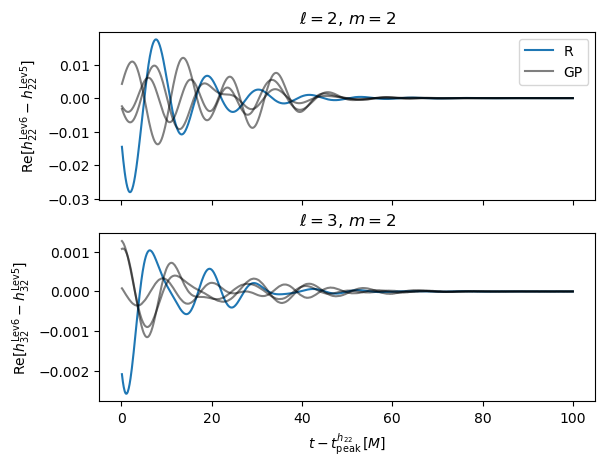

In [35]:
fig, axs = plt.subplots(len(spherical_modes), 1, sharex=True)

for i, (ell,m) in enumerate(spherical_modes):

    axs[i].plot(sim.times[analysis_mask]-t0, np.real(R[ell,m])[analysis_mask], label='R')

    repeats = 3
    gp_samples = rng.multivariate_normal(np.zeros(n_times), K_dict[ell,m], size=repeats)
    for j, draw in enumerate(gp_samples):
        label = 'GP' if j == 0 else None
        axs[i].plot(analysis_times, draw, color='black', alpha=0.5, label=label)

    axs[i].set_ylabel(f'$\mathrm{{Re}}[h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev}}} - h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev-1}}}]$')
    axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

axs[-1].set_xlabel('$t-t_\mathrm{peak}^{h_{22}}\, [M]$')

axs[0].legend();

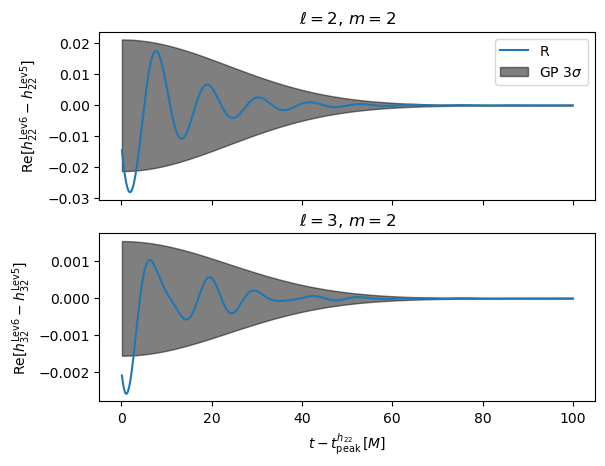

In [36]:
fig, axs = plt.subplots(len(spherical_modes), 1, sharex=True)

for i, (ell,m) in enumerate(spherical_modes):

    axs[i].plot(sim.times[analysis_mask]-t0, np.real(R[ell,m])[analysis_mask], label='R')

    # Plot the 3-sigma credible region of the GP
    axs[i].fill_between(
        analysis_times, 
        -3*np.sqrt(np.diag(K_dict[ell,m])), 
        3*np.sqrt(np.diag(K_dict[ell,m])),
        color='black', 
        alpha=0.5,
        label='GP 3$\sigma$'
        );

    axs[i].set_ylabel(f'$\mathrm{{Re}}[h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev}}} - h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev-1}}}]$')
    axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

axs[-1].set_xlabel('$t-t_\mathrm{peak}^{h_{22}}\, [M]$')

axs[0].legend();

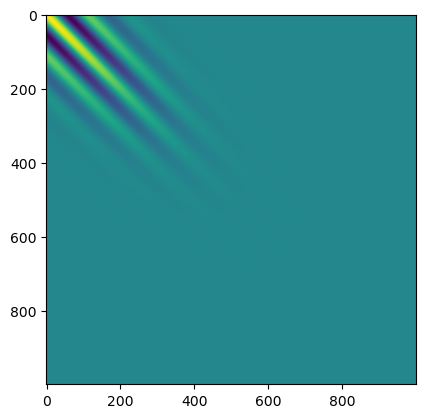

In [37]:
plt.imshow(K_dict[spherical_modes[0]]);

In [38]:
K_inv_dict = {(ell,m): np.linalg.inv(K_dict[ell,m]) for ell,m in spherical_modes}

Now do the Fisher matrix calculation with this new covariance:

In [39]:
fisher_matrix_gp = calculate_fisher_matrix(a_dict, K_inv_dict)

In [40]:
covariance_matrix_gp = np.linalg.inv(fisher_matrix_gp)

In [41]:
weighted_ls_C_gp = weighted_ls_fit(K_dict, a_dict, analysis_data_dict)

weighted_ls_re_c_im_c_gp = []
for c in weighted_ls_C_gp:
    weighted_ls_re_c_im_c_gp.append(np.real(c))
    weighted_ls_re_c_im_c_gp.append(np.imag(c))

Plot this result from the Fisher matrix alongside the previous `emcee` samples. We see that the result and correlations change significantly:

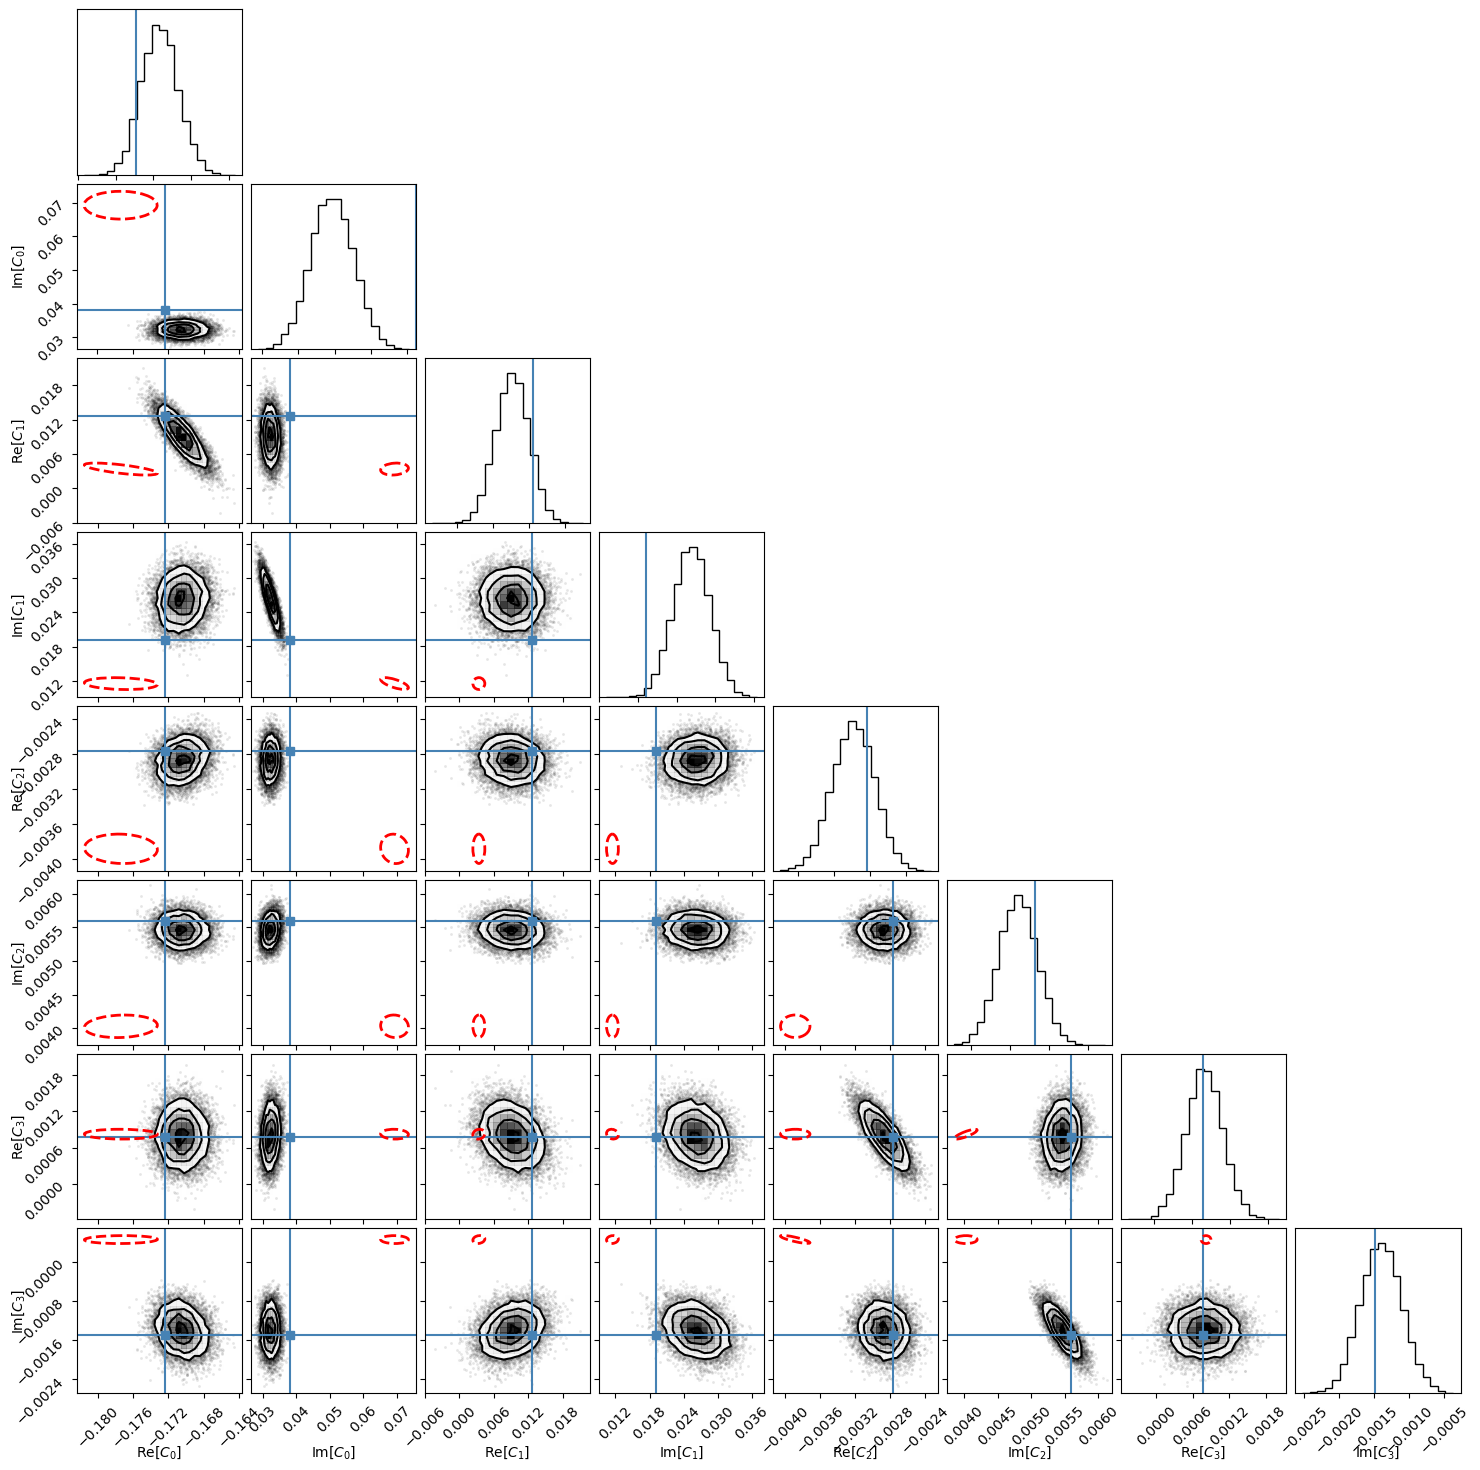

In [42]:
fig, axs = plt.subplots(2*n_qnms, 2*n_qnms, figsize=(15,15))

for i in range(2*n_qnms):
    for j in range(i):
        ellipse = plot_cov_ellipse(
            np.array(covariance_matrix_gp)[[j, i]][:, [j, i]], 
            [weighted_ls_re_c_im_c_gp[j], weighted_ls_re_c_im_c_gp[i]], 
            ax=axs[i,j], 
            edgecolor='red', 
            lw=2, 
            linestyle='--',
            fill=False, 
            zorder=5,
            nstd=2
            )
        
corner.corner(
    emcee_samples, 
    labels=labels,
    truths=ls_re_c_im_c,
    fig=fig
);

In [43]:
# Draw samples from the GP posterior
gp_posterior_samples = rng.multivariate_normal(
    weighted_ls_re_c_im_c_gp, 
    covariance_matrix_gp, 
    size=1000
    )

In [44]:
# Evaluate a waveform for each
gp_posterior_waveforms = {(ell,m): [] for (ell,m) in spherical_modes}
for sample in gp_posterior_samples:
    c = sample[::2] + 1j*sample[1::2]
    for ell, m in spherical_modes:
        gp_posterior_waveforms[ell,m].append(np.dot(a_dict[ell,m], c))

In [45]:
# Find the 5th and 95th credible region of the waveforms
gp_posterior_waveform_3sigma = {(ell,m): [] for (ell,m) in spherical_modes}
for ell, m in spherical_modes:
    for i in range(n_times):
        waveform_samples = [waveform[i] for waveform in gp_posterior_waveforms[ell,m]]
        gp_posterior_waveform_3sigma[ell,m].append(np.quantile(waveform_samples, [0.05, 0.95]))
    gp_posterior_waveform_3sigma[ell,m] = np.array(gp_posterior_waveform_3sigma[ell,m]).T

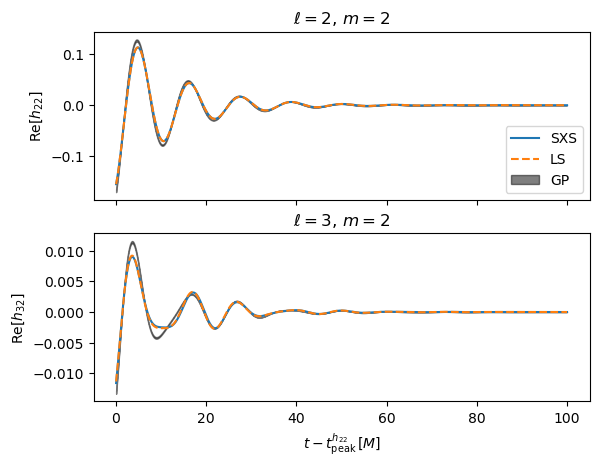

In [46]:
fig, axs = plt.subplots(len(spherical_modes), 1, sharex=True)

for i, (ell,m) in enumerate(spherical_modes):

    axs[i].plot(sim.times[analysis_mask]-t0, np.real(sim.h[ell,m])[analysis_mask], label='SXS')
    axs[i].plot(analysis_times, np.real(ls_fit['model'][ell,m]), linestyle='--', label='LS')
    
    axs[i].fill_between(
        analysis_times, 
        np.real(gp_posterior_waveform_3sigma[ell,m][0]), 
        np.real(gp_posterior_waveform_3sigma[ell,m][1]),
        color='black', 
        alpha=0.5,
        label='GP'
        );
    
    axs[i].set_ylabel(f'$\mathrm{{Re}}[h_{{{ell}{m}}}]$')
    axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

axs[-1].set_xlabel('$t-t_\mathrm{peak}^{h_{22}}\, [M]$')

axs[0].legend();

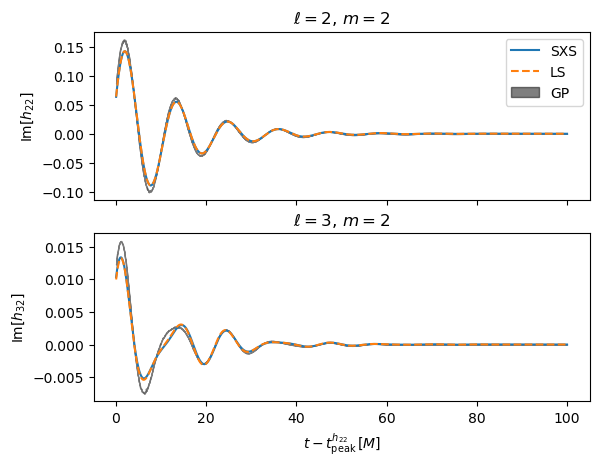

In [47]:
fig, axs = plt.subplots(len(spherical_modes), 1, sharex=True)

for i, (ell,m) in enumerate(spherical_modes):

    axs[i].plot(sim.times[analysis_mask]-t0, np.imag(sim.h[ell,m])[analysis_mask], label='SXS')
    axs[i].plot(analysis_times, np.imag(ls_fit['model'][ell,m]), linestyle='--', label='LS')

    axs[i].fill_between(
        analysis_times, 
        np.imag(gp_posterior_waveform_3sigma[ell,m][0]), 
        np.imag(gp_posterior_waveform_3sigma[ell,m][1]),
        color='black', 
        alpha=0.5,
        label='GP'
        );
    
    axs[i].set_ylabel(f'$\mathrm{{Im}}[h_{{{ell}{m}}}]$')
    axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

axs[-1].set_xlabel('$t-t_\mathrm{peak}^{h_{22}}\, [M]$')

axs[0].legend();